# Parte opcional - Cimbala

## Gráficos

Graficamos $\frac{X_i - \bar{X}}{S}$ para cada salto en la ruta para ver que pinta tiene

In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import taller2
import thomson

import seaborn as sns
import pandas as pd # name a more iconic duo
import matplotlib.pyplot as plt
import statistics
from typing import Tuple

sns.set_style("whitegrid")

In [49]:
def calculate_errors(stats: taller2.Stats) -> int:
    # Obtenemos la distribución de dRTTs
    drtts = []
    
    for i, hop in enumerate(stats):
        if "d_rtt" not in hop:
            continue
        
        drtts.append(hop["d_rtt"])
        
    # Calculamos la media y el desvio estandar
    media = statistics.mean(drtts)
    sd = statistics.stdev(drtts)

    # Calculamos el error, (x_i - media)/sd
    for i, hop in enumerate(stats):
        if "d_rtt" not in hop:
            continue

        hop["error"] = (hop["d_rtt"]-media)/sd

    return len(drtts)

def get_df(ip: str) -> Tuple[pd.DataFrame, int]:
    _, stats = taller2.deserialize(ip)
    taller2.extend_with_geo(stats)
    taller2.d_rtt(stats)
    n = calculate_errors(stats)
    
    df = pd.DataFrame(stats)
    df["hop"] = df.index
    return df[df["hop"] >= 1], n


In [50]:
IP_DELHI = "14.139.45.149"
IP_CMU = "128.2.42.52"
IP_OSAKA = "133.1.138.1"

HOPS_OSAKA = 22
HOPS_DELHI = 15
HOPS_CMU = 15

df_osaka, n_osaka = get_df(IP_OSAKA)
df_cmu, n_cmu = get_df(IP_CMU)
df_delhi, n_delhi = get_df(IP_DELHI)

In [51]:
def plot_errors(df: pd.DataFrame, hops: int, n: int):
    ax = sns.scatterplot(data=df[df["hop"] <= hops], x="hop", y="error", hue="country_name")
    ax.axhline(thomson.get_tabulated_value(n), ls=':', lw=1.5, color="black")
    ax.set(xlabel='Hop', ylabel='error')
    ax.set_title("RTT para cada hop")
    ax.set_xticks(range(1,hops+1))

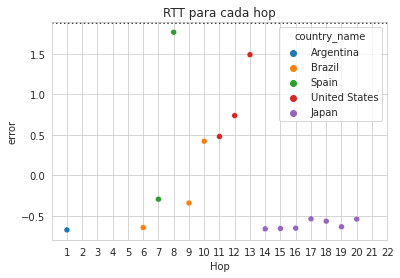

In [52]:
plot_errors(df_osaka, HOPS_OSAKA, n_osaka)

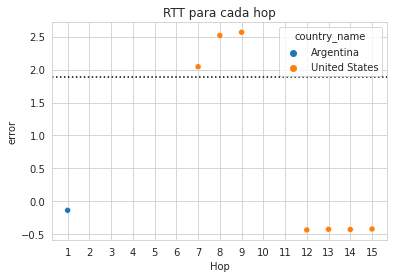

In [53]:
plot_errors(df_cmu, HOPS_CMU, n_cmu)

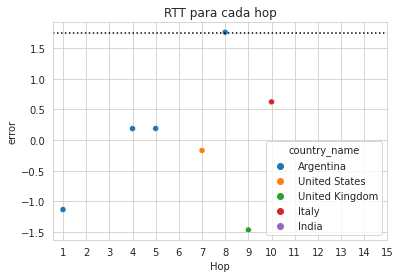

In [54]:
plot_errors(df_delhi, HOPS_DELHI, n_delhi)

In [140]:
def thomson_outlier_detection(ip: str, name: str, hops: int, hardcoded_t: int = None):
    _, stats = taller2.deserialize(ip)
    taller2.d_rtt(stats)
    taller2.extend_with_geo(stats)
    stats = stats[:hops+1]
    for i in range(len(stats)):
        stats[i]["hop"] = i

    # Obtenemos la distribución de dRTTs y filtramos por los que no tienen dRTT
    stats = list(filter(lambda d: "d_rtt" in d, stats))
    while len(stats) != 0:
        drtts = list(map(lambda d: d["d_rtt"], stats))

        t = hardcoded_t
        if t is None:
            t = thomson.get_tabulated_value(len(drtts))

        # Calculamos la media y el desvio estandar
        media = statistics.mean(drtts)
        sd = statistics.stdev(drtts)

        # Tomamos como outlier si (x_i - media) > t * sd
        before = len(stats)
        for i, hop in enumerate(stats):
            #print(f"[{hop['hop']}] media: {media}, drtt: {hop['d_rtt']}")
            hop["delta"] = abs(hop["d_rtt"]-media)
        
        stats.sort(key=lambda d: d["delta"], reverse=True) # desc
        hop = stats[0]
        delta = hop["delta"]
        if delta > t * sd:
            meta = ""
            if "org" in hop:
                meta = f"{hop['city']} - {hop['country_name']}"
            print(f"[{ip} ({name})] El hop #{hop['hop']} con ip {hop['IP']} ({meta}) es un outlier (delta={delta:.2f})")
            del stats[0]
        else:
            break

In [141]:
ips = [
    (IP_DELHI, "Delhi", HOPS_DELHI),
    (IP_CMU, "CMU", HOPS_CMU),
    (IP_OSAKA, "Osaka", HOPS_OSAKA),
]

for ip, name, hops in ips:
    thomson_outlier_detection(ip, name, hops)

[133.1.138.1 (Osaka)] El hop #5 con ip 10.192.18.12 () es un outlier (delta=124.34)
[133.1.138.1 (Osaka)] El hop #8 con ip 176.52.249.39 (Madrid - Spain) es un outlier (delta=89.50)
[133.1.138.1 (Osaka)] El hop #13 con ip 129.250.6.237 (San Jose - United States) es un outlier (delta=81.82)
[133.1.138.1 (Osaka)] El hop #12 con ip 129.250.2.144 (Ashburn - United States) es un outlier (delta=51.76)
[133.1.138.1 (Osaka)] El hop #11 con ip 129.250.8.117 (Ashburn - United States) es un outlier (delta=43.12)
[133.1.138.1 (Osaka)] El hop #10 con ip 94.142.98.192 (São Paulo - Brazil) es un outlier (delta=43.51)
[133.1.138.1 (Osaka)] El hop #7 con ip 213.140.39.116 (Madrid - Spain) es un outlier (delta=13.40)
[133.1.138.1 (Osaka)] El hop #9 con ip 94.142.98.123 (São Paulo - Brazil) es un outlier (delta=12.30)
